## Setup et Chargement

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import mord
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

# --- Chargement ---
csv_path = Path("../../data/features/DPE.csv")
if not csv_path.exists():
    raise FileNotFoundError(f"CSV introuvable : {csv_path.resolve()}")

df = pd.read_csv(csv_path)
TARGET = "conso_finale"

# Nettoyage rapide
y = pd.to_numeric(df[TARGET], errors="coerce")
leak_cols = ["code_postal", "type_energie_principale", TARGET]
X = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")

mask = y.notna()
X, y = X.loc[mask].copy(), y.loc[mask].copy()

# Split 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f"Data ready. Train: {X_train.shape[0]} | Test: {X_test.shape[0]} | Val: {X_val.shape[0]}")

Data ready. Train: 6090 | Test: 1305 | Val: 1305


## Pipeline de Preprocessing

### On définit comment traiter les colonnes numériques et catégorielles.

In [24]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ]
)

## Entraînement des Modèles

### On entraîne la Régression Continue (le modèle champion) et le Modèle Ordinal (pour la classification).

In [25]:
# --- 3.1 Régression Continue (Champion) ---
model_reg = Pipeline([
    ("prep", preprocess),
    ("algo", HistGradientBoostingRegressor(random_state=42))
])
model_reg.fit(X_train, y_train)

# --- 3.2 Régression Ordinale (Bins) ---
K = 12
ALPHA = 0.3
y_train_cls, bin_edges = pd.qcut(y_train, q=K, labels=False, retbins=True, duplicates="drop")

model_ord = Pipeline([
    ("prep", preprocess),
    ("algo", mord.LogisticAT(alpha=ALPHA))
])
model_ord.fit(X_train, y_train_cls.astype(int))

# Calcul des médianes pour la reconstruction
train_bins = pd.cut(y_train, bins=bin_edges, labels=False, include_lowest=True)
class_medians = y_train.groupby(train_bins).median().values

print(" Modèles entraînés avec succès.")

 Modèles entraînés avec succès.


# Évaluation et Visualisation

--- METRIQUES REGRESSION ---
MAE  : 1047.42
RMSE : 2189.92
R2   : 0.9696


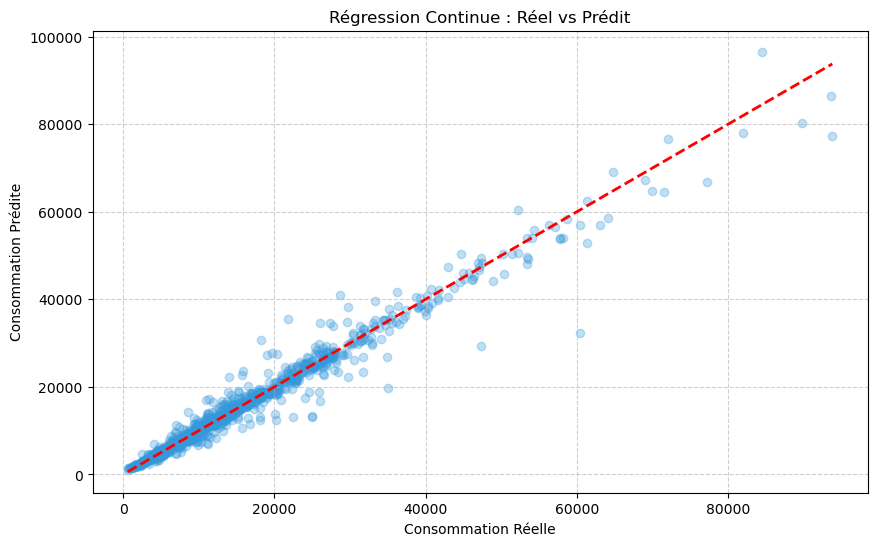

In [26]:
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, color='#3498db')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', lw=2)
    plt.xlabel("Consommation Réelle")
    plt.ylabel("Consommation Prédite")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Predictions
pred_reg = model_reg.predict(X_test)

print(f"--- METRIQUES REGRESSION ---")
print(f"MAE  : {mean_absolute_error(y_test, pred_reg):.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, pred_reg)):.2f}")
print(f"R2   : {r2_score(y_test, pred_reg):.4f}")

plot_results(y_test, pred_reg, "Régression Continue : Réel vs Prédit")

# Démo "Real-Life"

In [30]:
rng = np.random.default_rng()
idx = rng.choice(X_test.index)
x_sample = X_test.loc[[idx]]
y_real = y_test.loc[idx]

# 1. Prediction Continue
y_pred_cont = model_reg.predict(x_sample)[0]

# 2. Prediction Ordinale
y_pred_bin = model_ord.predict(x_sample)[0]
y_pred_from_bin = class_medians[int(y_pred_bin)]

print(f"=== TEST UNITAIRE (Index {idx}) ===")
print(f"Valeur Réelle         : {y_real:.2f}")
print(f"Prédit (Régression)   : {y_pred_cont:.2f} (Erreur: {abs(y_real-y_pred_cont)/y_real:.2%})")
print(f"Classe Bins (Ordinal) : {y_pred_bin} (Valeur correspondante: {y_pred_from_bin:.2f})")
print("-" * 30)
print("Caractéristiques principales :")
print(x_sample.iloc[0].dropna().head(10))

=== TEST UNITAIRE (Index 5557) ===
Valeur Réelle         : 6259.50
Prédit (Régression)   : 6228.44 (Erreur: 0.50%)
Classe Bins (Ordinal) : 4 (Valeur correspondante: 7291.05)
------------------------------
Caractéristiques principales :
type_batiment                  appartement
type_installation_chauffage     individuel
type_installation_ecs           individuel
hauteur_sous_plafond                   2.5
etiquette_dpe                            D
etiquette_ges                            B
surface_habitable_logement            58.2
nombre_niveau_logement                 1.0
isolation                            bonne
cout_conso                          1078.9
Name: 5557, dtype: object


# Extraction du model

In [28]:
# !pip install Path

In [ ]:
# BASE_DIR = Path.cwd().parent  # science/
# MODEL_DIR = BASE_DIR / "models"
# MODEL_DIR.mkdir(exist_ok=True)

# joblib.dump(
#     pred_reg_test,
#     MODEL_DIR / "dpe_Regression_xgb.joblib"
# )